In [1]:
import glob
import email
import re
import pandas as pd
import numpy as np
import math
import seaborn as sn
import matplotlib.pyplot as plt
from email import policy
from email.parser import BytesParser
from string import punctuation

As funções abaixo são utilizadas para a leitura dos emails. As tags HTML e as pontuações foram removidas.

In [2]:
def flat_text(text):
    new_text = ""
    html_tag = False
    for c in text:
        if(c == "<"):
            html_tag = True
            continue
        elif(c == ">"):
            html_tag = False
            continue
        if(html_tag == False):
            if(c not in punctuation):
                new_text += c
            else:
                new_text += " "
    return new_text.lower()

def email_parser():
    files = glob.glob("DATA\*.eml")
    emails_set = dict()
    for file in files:
        with open(file, 'rb') as fp:
            msg = BytesParser(policy=policy.default).parse(fp)
            try:
                text = msg.get_body(preferencelist=('plain')).get_content()
            except:
                text.encode('utf-32', 'surrogateescape').decode('utf-32') 
            new_text = flat_text(text)    
            words_set = dict()
            email_words = re.split(" |\n|\t", new_text)
            for word in email_words:
                try:
                    words_set[word] += 1
                except:
                    words_set[word] = 1
            emails_set[file.split("\\")[1]] = words_set
    return emails_set        

def label_parser():
    file = open("SPAMTrain.label", "r")
    labels_set = dict()
    if file.mode == 'r':
        for line in file.readlines():
            vec = line.split(" ")
            labels_set[vec[1].replace('\n', '')] = vec[0]
    return labels_set
    

In [3]:
emails = email_parser()
labels = label_parser()

Essa função separa o conjunto de teste do conjunto de treinamento. Nesta execução o conjunto de treinamento representa 80% da base de dados.

In [4]:
def train_test_split(x,y, train_size = 0.8):
    perm = np.random.permutation(list(x.keys()))
    dict_size = len(x)
    x_train = dict()
    y_train = dict()
    x_test = dict()
    y_test = dict()
    i = 0
    index = len(x)*train_size
    for k in perm:
        if (i < index):
            x_train[k] = x[k] 
            y_train[k] = y[k]
        else:
            x_test[k] = x[k] 
            y_test[k] = y[k]
        i += 1
    return x_train, y_train, x_test, y_test

In [5]:
email_train, label_train, email_test, label_test = train_test_split(emails, labels)

A classe NaiveBayes representa um classificador com suas funções de treinamento e predição. 

In [6]:
class NaiveBayes:
    
    p_spams = dict() #P(word|spam)
    p_hams = dict() #P(word|ham)
    p_spam = 0 #P(spam)
    p_ham = 0  #P(ham)
    n_spam = 0 #Qtd total de palavras em spam
    n_ham = 0 #Qtd total de palavras em ham
    dict_size = 0 #Qtd de palavras distintas nos emails
    
    def __init__(self, k = 1):
        self.k = k
        
    def set_k(self, k):
        self.k = k
        
    def divide(self, emails, labels):
        spams = 0
        hams = 0
        words_spam = dict()
        words_ham = dict()
        words = dict()
      
        for item in emails:
            if(int(labels[item]) == 0):
                spams += 1
                for word in emails[item]:
                    try:
                        words_spam[word] += emails[item][word]
                    except:
                        words_spam[word] = emails[item][word]
                    try:
                        words[word] += emails[item][word]
                    except:
                        words[word] = emails[item][word]
                    self.n_spam  += emails[item][word]
            else:
                hams += 1
                for word in emails[item]:
                    try:
                        words_ham[word] += emails[item][word]
                    except:
                        words_ham[word] = emails[item][word]
                    try:
                        words[word] += emails[item][word]
                    except:
                        words[word] = emails[item][word]
                    self.n_ham += emails[item][word]
                    
        return words, words_spam, words_ham, spams, hams
    
    def fit(self, emails, labels):
        words, words_spam, words_ham, spams, hams = self.divide(emails, labels)
        self.p_spam = (spams + self.k)/(spams + hams + 2*self.k) #P(spam)
        self.p_ham = (hams + self.k)/(spams + hams + 2*self.k) #P(ham)
        self.dict_size = len(words)
        for item in words:
            try:
                self.p_spams[item] = (words_spam[item] + self.k)/(self.n_spam + (self.k*self.dict_size))
            except:
                self.p_spams[item] = (self.k)/(self.n_spam + (self.k*self.dict_size))
            try:
                self.p_hams[item] = (words_ham[item] + self.k)/(self.n_ham + (self.k*self.dict_size))
            except:
                self.p_hams[item] = (self.k)/(self.n_ham + (self.k*self.dict_size))

    def predict(self, emails):
        labels = list()
        for item in emails:
            p_bespam = math.log(self.p_spam)
            p_beham = math.log(self.p_ham)
            for word in emails[item]:
                try:
                    p_bespam += math.log(self.p_spams[word])
                except:
                    p_bespam += math.log((self.k)/(self.n_spam + (self.k*self.dict_size)))
                try:
                    p_beham += math.log(self.p_hams[word]) 
                except:
                    p_beham += math.log((self.k)/(self.n_ham + (self.k*self.dict_size)))
            labels.append(1 if p_bespam<p_beham else 0)
        return labels

In [7]:
nb = NaiveBayes()

A função accuracy retorna a acuracia do classificador, dado o retorno da função NaiveBayes.predict e os valores esperados.

In [8]:
def accuracy(prediction, labels_val):
    num = 0
    total = 0
    for i in labels_val:
        if(prediction[total] == int(labels_val[i])):
            num += 1
        total += 1
    return num/total

A classe grid_search_cv contém os métodos para a realização da validação cruzada e escolha do melhor parâmetro k para NaiveBayes.
Ela é fácilmente adaptável para a inserção de outros hiperparâmetros ou o teste de outros classificadores

In [9]:
class grid_search_cv:
    
    x = dict()
    y = dict()
    
    def __init__(self, clf, params, cv = 10):
        self.clf = clf
        self.params = params
        self.cv = cv
        
    def kfold(self, k, param):
        size_part = len(self.x)//k
        perm = np.random.permutation(list(self.x.keys()))
        self.clf.set_k(param)
        acc = 0
        for i in range(k):
            val_part_keys = perm[size_part*i:(size_part*(i+1))-1] 
            train_x = dict()
            train_y = dict()
            val_x = dict()
            val_y = dict()
            for key in self.x:
                if(key in val_part_keys):
                    val_x[key] = self.x[key]
                    val_y[key] = self.y[key]
                else:
                    train_x[key] = self.x[key]
                    train_y[key] = self.y[key]
            self.clf.fit(train_x, train_y)
            prediction = self.clf.predict(val_x)
            acc += accuracy(prediction, val_y)
        return acc/k
    
    def fit(self, x, y):
        self.x = x
        self.y = y
        best_acc = 0
        for i in self.params:
            acc = self.kfold(self.cv, i)
            print("k: ", i, " Acurácia: ", acc)
            if(acc > best_acc):
                best_acc = acc
                best_param = i
        print("K escolhido para a suavização aditiva: ", best_param)
        self.clf.set_k(best_param)
        self.clf.fit(x,y) #treinar o classificador de novo com o conjunto todo
        
            

In [10]:
params = np.arange(0.1,1,0.1)
gs = grid_search_cv(nb, params)

A escolha do hiperparâmetro é feita a seguir com base no que retorna a maior acurácia média:

In [11]:
gs.fit(email_train, label_train)

k:  0.1  Acurácia:  0.9837681159420288
k:  0.2  Acurácia:  0.9828985507246377
k:  0.30000000000000004  Acurácia:  0.9799999999999999
k:  0.4  Acurácia:  0.9788405797101449
k:  0.5  Acurácia:  0.9756521739130435
k:  0.6  Acurácia:  0.9742028985507247
k:  0.7000000000000001  Acurácia:  0.9753623188405797
k:  0.8  Acurácia:  0.9736231884057972
k:  0.9  Acurácia:  0.9742028985507247
K escolhido para a suavização aditiva:  0.1


Ao rodar o nosso classificador com o conjunto de teste separado anteriormente encontramos a acurácia de 96%

In [12]:
pred = gs.clf.predict(email_test)

In [13]:
accuracy(pred, label_test)

0.9641618497109826

Abaixo podemos ver a matriz de confusão da versão final do classificador:

In [21]:
def confusion_matrix(prediction, labels):
    tp = 0
    tn = 0
    fn = 0
    fp = 0
    j = 0
    for i in labels:
        if(prediction[j] == 1 and int(labels[i]) == 1):
            tp += 1
        elif(prediction[j] == 1 and int(labels[i]) == 0):
            fp += 1
        elif(prediction[j] == 0 and int(labels[i]) == 0):
            tn += 1
        else:
            fn += 1
        j += 1
    array = [[tp/j, fp/j],
             [fn/j, tn/j]]
    return array

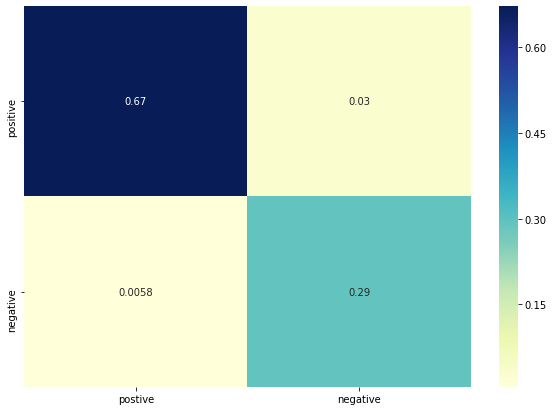

In [24]:
array = confusion_matrix(pred, label_test)
df_cm = pd.DataFrame(array, index = ["positive", "negative"],
                  columns = ["postive", "negative"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, cmap="YlGnBu", annot=True)